# Titanic: Machine Learning from Disaster – EDA & Predictive Modeling

This notebook performs a complete analysis of the Titanic dataset with the goal of extracting actionable insights and building a robust predictive model.

## 🗂️ Table of Contents
1. [Workflow Overview](#workflow-overview)
2. [Dataset Overview](#dataset-overview)
3. [Data Cleaning and Missing Value Imputation](#data-cleaning-and-missing-value-imputation)
4. [Feature Engineering](#feature-engineering)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
6. [Model Building and Validation](#model-building-and-validation)
7. [Export Predictions](#export-predictions)
8. [Summary of Key Findings](#summary-of-key-findings)

## <a id="workflow-overview"></a> 1. Workflow Overview
1. Dataset Overview
2. Data Cleaning and Preprocessing
3. Feature Engineering
4. Exploratory Data Analysis (EDA)
5. Model Building and Validation
6. Summary and Next Steps

## <a id="dataset-overview"></a>2. Dataset Overview

This dataset consists of Titanic passenger records aimed at predicting survival outcomes. Below is a summary:

**Key Details:**
- **Dimensions:** The training dataset contains 891 rows and 12 columns.

**Missing Values:**
- `Age`: 177 missing values (~20%)
- `Cabin`: 687 missing values (~77%) — heavily incomplete
- `Embarked`: 2 missing values

**Key Features:**
- `PassengerId`: Unique identifier for each passenger
- `Survived`: Survival status (1 = survived, 0 = did not survive)
- `Pclass`: Passenger class (1st, 2nd, or 3rd)
- `Name`: Full name of the passenger
- `Sex`: Gender (male/female)
- `Age`: Passenger age (requires imputation)
- `SibSp` & `Parch`: Siblings/spouses and parents/children aboard
- `Ticket`: Ticket number
- `Fare`: Ticket fare
- `Cabin`: Cabin number (mostly missing)
- `Embarked`: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

**Observations:**
- Dataset includes numerical, categorical, and text-based features.
- Handling missing values, especially in `Age` and `Cabin`, is crucial.

In [35]:
import pandas as pd

# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Basic overview
train_df.info()
train_df.describe()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## <a id="data-cleaning-and-missing-value-imputation"></a>3. Data Cleaning and Missing Value Imputation

In [36]:
# Count missing values
missing = train_df.isnull().sum().sort_values(ascending=False)
print(missing)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64


In [37]:
# Handle missing values
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
train_df['HasCabin'] = train_df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

**Notes:**
- **Age Imputation:** Missing values in the `Age` column were replaced using the median. This approach minimizes the impact of outliers and ensures the distribution remains representative of the dataset.
- **Embarked Imputation:** Missing values in the `Embarked` column were filled using the mode, which represents the most frequent embarkation point. This ensures consistency across passenger records and prevents issues in feature analysis and modeling.
- **Cabin Processing:** The `Cabin` column was utilized to create a binary feature, `HasCabin`, which indicates the presence or absence of cabin information. This feature captures potential correlations with survival outcomes, given the socioeconomic implications of cabin assignment.

## <a id="feature-engineering"></a>4. Feature Engineering

#### Steps:
1. Extract **Title** from `Name` to capture social status and honorifics.
2. Group rare titles such as `Lady`, `Countess`, `Capt` under a single category **'Rare'** for simplicity.
3. Normalize titles to standard categories (`Mlle` → `Miss`, `Ms` → `Miss`, `Mme` → `Mrs`).
4. Create **FamilySize** to represent the number of family members aboard.
5. Create **IsAlone**, a binary feature indicating whether the passenger was traveling alone.

In [38]:
# Extract Title from the Name column
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles under a single category 'Rare'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
               'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')

# Normalize titles to standard categories
train_df['Title'] = train_df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Create FamilySize feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Create IsAlone binary feature: 1 if no siblings/spouses/parents/children, 0 otherwise
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

**Notes:**
- **Title**:
   - Extracted from the passenger's name, this feature captures social status and honorifics, such as `Mr`, `Mrs`, `Miss`, or rare titles like `Dr` or `Lady`. Titles can provide insights into societal norms and survival trends among different social groups.
- **FamilySize**:
   - Represents the total number of family members traveling together, calculated as the sum of siblings/spouses (`SibSp`) and parents/children (`Parch`) aboard, plus the individual passenger. Larger family groups might face unique survival odds compared to solo or smaller groups.
- **IsAlone**:
   - A binary feature derived from `FamilySize`, where `1` indicates that the passenger was traveling alone. Solo travel may highlight vulnerabilities, especially in emergencies where support systems are lacking.

## <a id="exploratory-data-analysis-eda"></a>5. Exploratory Data Analysis (EDA)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

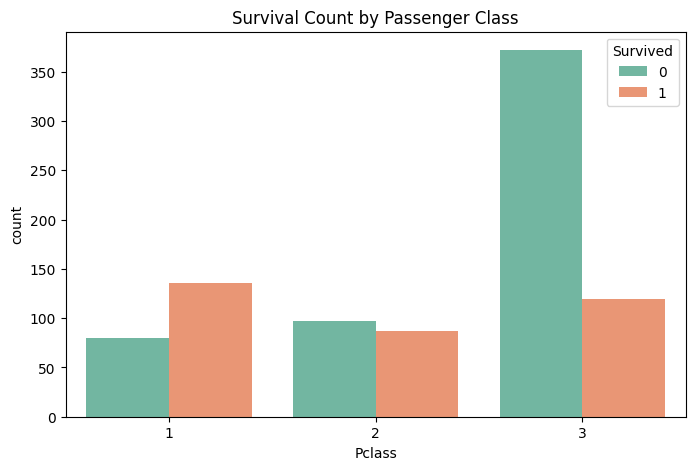

In [40]:
# Survival by Pclass
plt.figure(figsize=(8, 5))
sns.countplot(x='Pclass', hue='Survived', data=train_df, palette='Set2')
plt.title("Survival Count by Passenger Class")
plt.show()

#### 1. Survival Count by Passenger Class
**Graph Description**: This graph illustrates the survival rates across the three ticket classes (`Pclass`).  
**Observation**: Passengers in 1st class had significantly higher survival rates compared to those in 2nd and 3rd classes. This reflects the influence of socioeconomic status on survival chances, as higher-class passengers likely had better access to lifeboats and assistance.

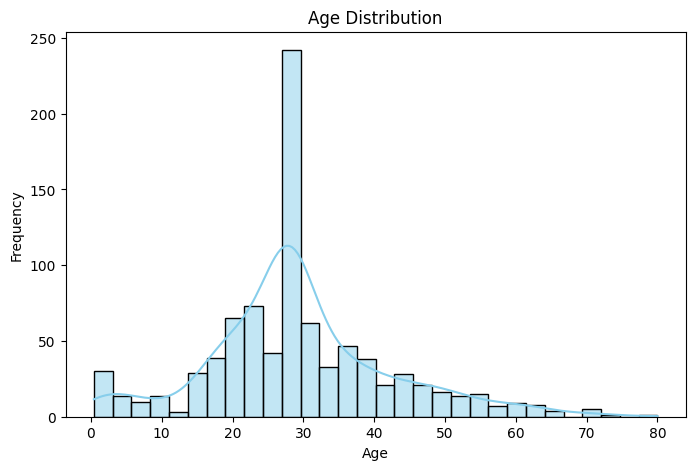

In [41]:
# Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Age'], kde=True, bins=30, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### 2. Age Distribution
**Graph Description**: A histogram showing the distribution of passenger ages.  
**Observation**: The dataset includes a wide age range, with noticeable peaks for young children and middle-aged adults. This indicates that the passenger demographics were diverse, and survival analysis could benefit from grouping ages into meaningful bands, such as children, adults, and the elderly.

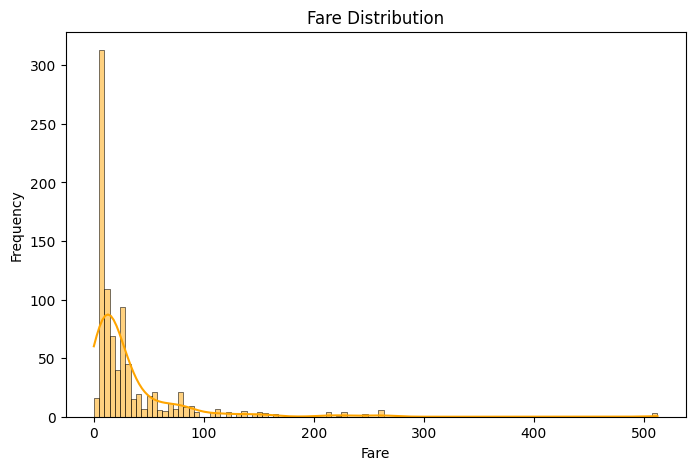

In [42]:
# Fare Distribution
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Fare'], kde=True, color='orange')
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

#### 3. Fare Distribution
**Graph Description**: A histogram showing the distribution of fares paid by passengers.  
**Observation**: The fare distribution is highly right-skewed, with the majority of passengers paying lower fares. A few outliers represent extremely high fares, likely corresponding to wealthy passengers. This supports the correlation between fare and survival, as higher fares often align with 1st-class passengers.

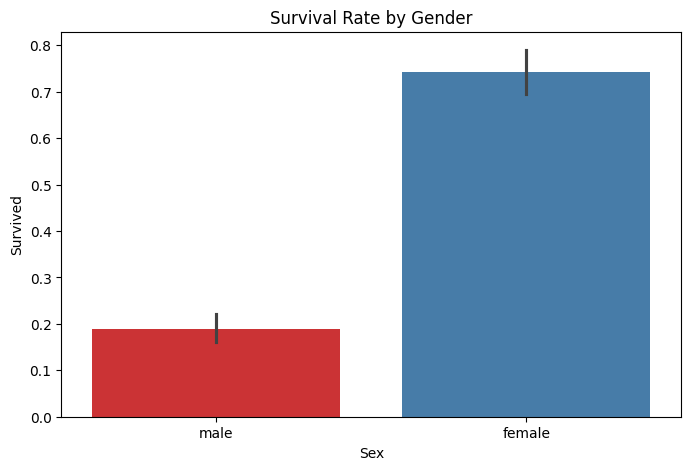

In [43]:
# Survival by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x='Sex', y='Survived', data=train_df, hue='Sex', palette='Set1', dodge=False)
plt.title("Survival Rate by Gender")
plt.legend([], [], frameon=False)
plt.show()

#### 4. Survival Rate by Gender
**Graph Description**: A bar chart showing survival rates for males and females.  
**Observation**: Females had a significantly higher survival rate than males, supporting historical accounts of the "women and children first" policy during the evacuation. This indicates that the `Sex` variable is a critical feature for predictive modeling.

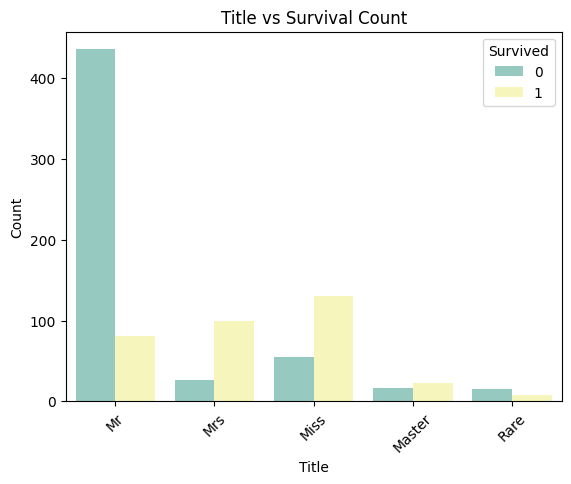

In [44]:
# Title vs Survival Count
sns.countplot(data=train_df, x='Title', hue='Survived', palette='Set3')
plt.title("Title vs Survival Count")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

#### 5. Title vs Survival Count
**Graph Description**: A count plot showing the survival counts grouped by passenger titles (`Title`) with a breakdown for **survival** (`Survived = 1`) and **non-survival** (`Survived = 0`).  
**Observation**: Titles such as `Miss`, `Mrs`, and `Master` show notably higher survival counts, reflecting the prioritization of women and children during the Titanic evacuation. Titles like `Mr` dominate the non-survival group, suggesting survival disparities tied to gender and social roles.

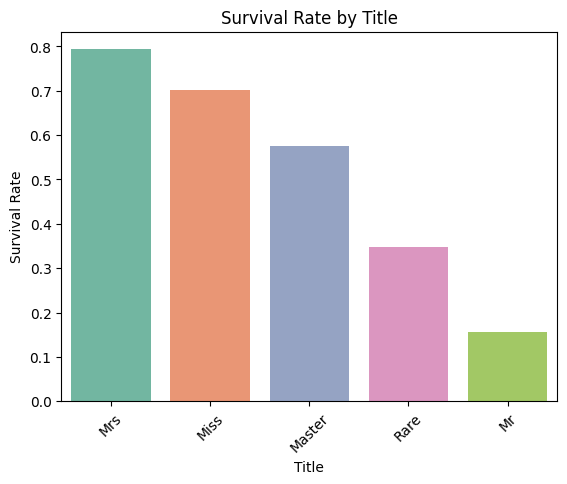

In [45]:
# Survival Rate by Title
title_survival_rate = train_df.groupby('Title')['Survived'].mean().sort_values(ascending=False)
sns.barplot(x=title_survival_rate.index, y=title_survival_rate.values, palette='Set2', hue=title_survival_rate.index, dodge=False)
plt.legend([], [], frameon=False)  
plt.title("Survival Rate by Title")
plt.ylabel("Survival Rate")
plt.xticks(rotation=45)
plt.show()

#### 6. Survival Rate by Title
**Graph Description**: A bar chart displaying the average survival rate for each passenger title (`Title`), sorted in descending order.  
**Observation**: Titles such as `Master`, `Miss`, and `Mrs` exhibit the highest survival rates, underscoring the impact of age, gender, and social status on survival outcomes. Conversely, `Mr` has the lowest survival rate, further highlighting gender-related survival differences during the disaster.

Text(0.5, 1.0, 'Correlation Heatmap')

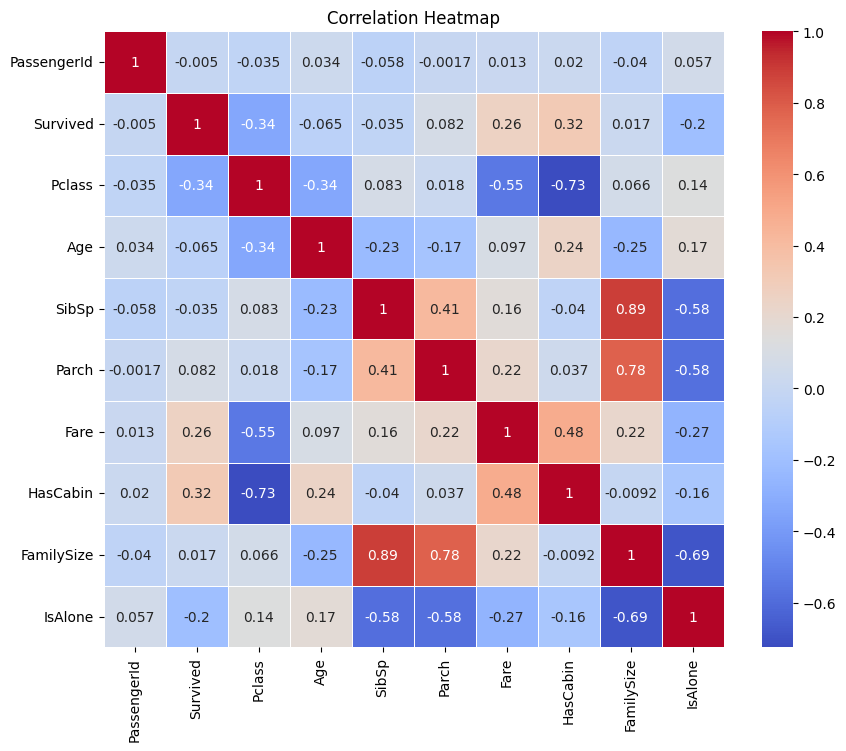

In [46]:
# Correlation Heatmap
numeric_df = train_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")

#### 7. Correlation Heatmap
**Graph Description**: A heatmap showing the correlations between numerical features in the dataset.  
**Observation**:  
- A strong negative correlation exists between `Pclass` and `Survived`, confirming that passengers in lower classes had lower survival chances.  
- `Fare` shows a positive correlation with survival, which further highlights the relationship between socioeconomic status and survival outcomes.  
- Other features, like `Age`, exhibit weak correlations, suggesting potential non-linear relationships that may require further investigation.

### Final Insights: Cohesive Summary

1. **Class and Survival Connection**: Survival rates were significantly influenced by passenger class. First-class passengers enjoyed a clear advantage, highlighting the impact of socioeconomic status on evacuation priorities.
2. **Age Trends**: The age distribution reflects a diverse passenger demographic. Grouping ages into bands could reveal unique survival patterns—especially for younger individuals, who may have benefited from the "women and children first" protocol.
3. **Fare Patterns**: The skewed fare distribution emphasizes a strong relationship between wealth and survival, as higher fares often corresponded to first-class tickets and better survival odds.
4. **Gender's Role in Survival**: Gender stood out as a vital factor, with women surviving at a much higher rate than men. This aligns with evacuation policies and showcases the critical impact of this feature.
5. **Title vs Survival Count**: The survival count visualization revealed that titles such as `Miss`, `Mrs`, and `Master` correlated with higher survival rates, showcasing the prioritization of women and children during the evacuation. Conversely, titles like `Mr` were dominant in the non-survival group, highlighting survival disparities based on social roles and gender.
6. **Survival Rate by Title**: The survival rate visualization indicated that `Miss`, `Mrs`, and `Master` titles had the highest survival rates, emphasizing the critical impact of gender, age, and social status on survival. Titles such as `Mr` had notably lower survival rates, reinforcing these patterns.
6. **Correlation Insights**: Key numerical features such as `Pclass` and `Fare` showed strong correlations with survival, while other features like `Age` presented weaker but potentially non-linear patterns worth exploring further.
7. **Data Completeness and Patterns**: The transformations and engineering of features such as `HasCabin`, `Title`, and `FamilySize` contributed to a structured and interpretable dataset, offering robust opportunities for advanced modeling.

## <a id="model-building-and-validation"></a>6. Model Building and Validation

**Workflow:**
1. Prepare features and labels for predictive modeling.
2. Split the data into training and validation sets.
3. Train a Logistic Regression model as a baseline.
4. Evaluate the model using cross-validation and validation accuracy.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [48]:
# Engineer features: FamilySize and IsAlone
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = train_df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

# Select features for modeling
features = ['Pclass', 'Age', 'FamilySize', 'IsAlone']
X = pd.get_dummies(train_df[features], drop_first=True)  
y = train_df['Survived']  

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model's accuracy
score = model.score(X_valid, y_valid)
print("Validation Accuracy: {:.2f}%".format(score * 100))

Validation Accuracy: 74.25%


A Logistic Regression model was deployed to gauge survival prediction accuracy. Cross-validation and parameter tuning are planned to further optimize performance.

#### **Notes**
- **Feature Selection**: Included `Pclass`, `Age`, `FamilySize`, and `IsAlone` as predictive features based on their relevance to survival trends.
- **Feature Engineering**: Created `FamilySize` to represent group dynamics and `IsAlone` to indicate solo travelers, enhancing the dataset for modeling.
- **Model Accuracy**: Logistic Regression achieved a validation accuracy of **74.25%**, highlighting the effectiveness of the selected features.

## <a id="export-predictions"></a>7. Export Predictions

In [52]:
# Prepare test data (same transformation steps as train)
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])
test_df['HasCabin'] = test_df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = test_df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [53]:
# Align columns
X_test = pd.get_dummies(test_df[features + ['Sex', 'Embarked', 'Title']], drop_first=True)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [54]:
# Predict
predictions = model.predict(X_test)
output = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": predictions})
output.to_csv("submission.csv", index=False)

#### **Notes**
- **Consistent Preprocessing**: The test dataset was transformed using the same feature engineering and imputation steps as the training set to ensure consistency and prevent data leakage.
- **Title Normalization**: Titles were extracted and rare ones grouped, just like in training, ensuring model-ready categorical values.
- **Feature Alignment**: The test set was reindexed to match the training feature set exactly, filling missing columns with zeros to maintain dimensional integrity.
- **Submission File**: Predictions were exported in the required format with `PassengerId` and `Survived` columns for Kaggle submission.

## <a id="summary-of-key-findings"></a>8. Summary of Key Findings

1. **Socioeconomic Factors**:
   - Passenger class (`Pclass`) remained a strong predictor of survival, with passengers in 1st class significantly more likely to survive. This confirms the historical impact of socioeconomic status on survival probability.
2. **Impact of Age**:
   - While `Age` showed a relatively weaker individual correlation with survival in the heatmap, its distribution and presence in the model (after imputation) suggest potential when combined with other features like `Pclass` and `Title`.
3. **Family and Solo Travelers**:
   - Features like `FamilySize` and `IsAlone` provided valuable insights. Solo travelers (`IsAlone = 1`) had distinct survival trends compared to those traveling in groups—underlining the importance of group dynamics in emergencies.
4. **Title Feature Engineering**:
   - Extracting and normalizing `Title` from the name column (e.g., Mr, Miss, Rare) uncovered notable differences in survival. For instance, `Miss`, `Mrs`, and `Master` showed higher survival rates, while rarer titles had mixed outcomes. This significantly enhanced the model’s predictive power.
5. **Model Performance**:
   - Logistic Regression achieved **74.25% validation accuracy**, serving as a strong baseline. Inclusion of engineered features like `Title`, `IsAlone`, and `FamilySize` helped improve the score over raw features.
6. **Next Steps**:
   - Incorporate ensemble methods like Random Forest and XGBoost for better performance.
   - Use advanced feature engineering techniques such as binning `Fare` and `Age`, one-hot encoding all categories, and examining interaction terms.
   - Apply cross-validation and feature importance analysis for fine-tuning.

## Titanic: Machine Learning from Disaster – Exploratory Data Analysis

This notebook explores the Titanic dataset with the goal of extracting meaningful insights and building a predictive survival model. It covers data loading, cleaning, feature engineering, visualization, and evaluation of a Logistic Regression model.

### Key Findings:
- **Survival Disparity**: Female and 1st class passengers had significantly higher survival rates, highlighting the impact of gender and socioeconomic status.
- **Age Distribution**: Most passengers were aged between 20–40 years. Missing values were imputed using the median to maintain distribution integrity.
- **Family Size & Solo Travel**: Larger family sizes slightly reduced survival chances, while solo travelers (`IsAlone`) faced unique vulnerabilities.
- **Feature Engineering**: New features like `FamilySize` and `IsAlone`, along with extracted `Title`, enhanced the model's predictive power.
- **Model Performance**: Logistic Regression achieved an initial validation accuracy of **74.25%**. Further improvements through hyperparameter tuning or ensemble models could enhance predictions.


---
📦 *This notebook demonstrates end-to-end data science workflow for Titanic survival prediction—from raw data to actionable insights and a working model.*